In [1]:
%load_ext autoreload
%matplotlib inline
# %config InlineBackend.figure_format = ‘retina’

In [9]:

%autoreload 2

from IPython import display

# from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import Adam

In [3]:
import matplotlib.pyplot as plt
import helper

In [4]:
import pandas as pd

In [5]:
import numpy as np

# Image Dataset Load

In [6]:
def mean_std(temp):
    totalMean = []
    totalStd = []
    meanL = 0
    stdL = 0
    
    for batch_id,(image,label) in enumerate(temp):
        img = image.numpy()
        meanL = np.mean(img,axis=(0,1,2))
        stdL = np.std(img,axis=(0,1,2))
        totalMean.append(meanL)
        totalStd.append(stdL)
        
    return totalMean,totalStd

In [39]:
transform = {
    'train': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.39099613,0.39099613,0.39099613], std = [0.1970754,0.1970754,0.1970754])
#         transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.39099613,0.39099613,0.39099613], std = [0.1970754,0.1970754,0.1970754])
#         transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
    ])
}

In [40]:
PATH = 'data/Kaggle_Monkey/'

In [41]:
#using torchvision ImageFolder for importing this dataset
trainData = torchvision.datasets.ImageFolder(root=PATH+'training',transform=transform['train'])
trainDataLoader = DataLoader(trainData,batch_size=4,shuffle=False,num_workers=4)
valData = torchvision.datasets.ImageFolder(root=PATH+'validation',transform=transform['val'])
valDataLoader = DataLoader(valData,batch_size=4,shuffle=False,num_workers=4)

In [42]:
#Load the types of classes
trainDataLoader.dataset.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [43]:
#What each class signifies in this model from n0-n9
dfAllClasses = pd.read_csv(PATH+'monkey_labels.txt')
label = [str.strip(x) for x in list(dfAllClasses[dfAllClasses.columns[2]])]
label

['mantled_howler',
 'patas_monkey',
 'bald_uakari',
 'japanese_macaque',
 'pygmy_marmoset',
 'white_headed_capuchin',
 'silvery_marmoset',
 'common_squirrel_monkey',
 'black_headed_night_monkey',
 'nilgiri_langur']

In [44]:
#Different visualization for train and test Data
valCnt = []
trainCnt = []

def countSamples(loader):
    temp = []
    for cls in range(10):
        tempCnt = 0
        for x in loader:
            if(cls == x[1]):
                tempCnt+=1

        temp.append(tempCnt)
    return temp    

trainCnt = countSamples(trainDataLoader.dataset.imgs)
valCnt = countSamples(valDataLoader.dataset.imgs)

#DATAFRAME
df = pd.DataFrame(data={'Class':label,'Train samples':trainCnt,'Val samples':valCnt})

print(df)

                       Class  Train samples  Val samples
0             mantled_howler            105           26
1               patas_monkey            111           28
2                bald_uakari            110           27
3           japanese_macaque            122           30
4             pygmy_marmoset            105           26
5      white_headed_capuchin            113           28
6           silvery_marmoset            106           26
7     common_squirrel_monkey            114           28
8  black_headed_night_monkey            106           27
9             nilgiri_langur            105           26


Text(0, 0.5, 'Monkey categories')

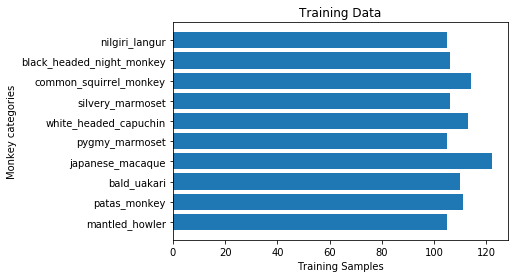

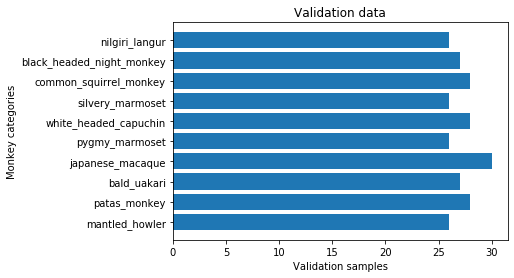

In [45]:
#Line bars
#Train set
fig0, ax0 = plt.subplots()
ax0.barh(label,trainCnt)
ax0.set_title('Training Data')
ax0.set_xlabel('Training Samples')
ax0.set_ylabel('Monkey categories')

#Validation set
fig1, ax1 = plt.subplots()
ax1.barh(label,valCnt)
ax1.set_title('Validation data')
ax1.set_xlabel('Validation samples')
ax1.set_ylabel('Monkey categories')

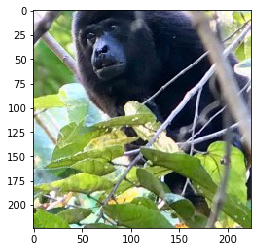

In [48]:
# ploting single image

#PLOTTING un-normalized data
temp = trainDataLoader.dataset[2][0].numpy()
temp = [0.1970754,0.1970754,0.1970754]*np.transpose(temp,axes=[1,2,0])+ [0.39099613,0.39099613,0.39099613]
#temp = [0.5,0.5,0.5]*np.transpose(temp,axes=[1,2,0])+ [0.5,0.5,0.5]
plt.imshow(temp)

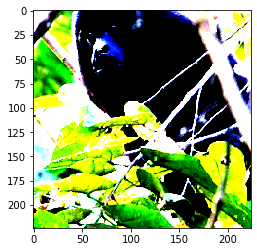

In [49]:
#PLOTTING normalized data
temp = trainDataLoader.dataset[2][0].numpy()
# temp = [0.1970754,0.1970754,0.1970754]*np.transpose(temp,axes=[1,2,0])+ [0.39099613,0.39099613,0.39099613]
plt.imshow(np.transpose(temp,axes=[1,2,0]))

In [50]:
#Creating GPU device variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [51]:
# dataiter=iter(trainDataLoader)
# images,labels=next(dataiter)
# print(images.shape)
# print(labels.shape)
# fig = plt.figure()
# for i in range(24):
#     plt.subplot(8,3,i+1)
# #     plt.tight_layout()
#     plt.imshow(images[i].numpy().transpose((1, 2, 0)))
#     plt.title(labels[i])
#     plt.xticks([])
#     plt.yticks([])
# fig

In [52]:

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
#     if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
#     if torch.cuda.is_available(): return data.cuda()
    return data

In [53]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [54]:
num_test_samples = 16
test_noise = noise(num_test_samples)

NameError: name 'noise' is not defined

In [55]:
def train_model(model,mode,decay,criterion,optimizer,scheduler,dataloader,dictionary,num_epochs=12):
    correct = 0
    total = 0
    LR = 0
    totalLoss = []
    totalPrediction = []
    totalLRs = []
    for epoch in range(num_epochs):
        print("Epoch {}/{} ".format(epoch,num_epochs-1),flush=False)
        scheduler.step()
        
        if(decay == True):
            for params in optimizer.param_groups:
                LR = params['lr'] * (0.1**(epoch//7))
                params['lr'] = LR
            totalLRs.append(LR)
            
        if(mode == True):
            model.train()
        else:
            model.eval()
        
        for batch_id,(image,label) in enumerate(dataloader):
            optimizer.zero_grad()
            
#             image = image.to(device)
#             label  = label.to(device)
            
            outputs = model(image)     #forward-propogation
            _, predictionIndex = torch.max(outputs,1)    #predicted index
            loss = criterion(outputs,label)
            print("Batch "+str(batch_id)+" Loss = {0:.5f}".format(loss),end='\r',flush=True)
            
            correct += (predictionIndex == label).sum().item()
            total += label.size(0)
            totalPrediction.append(correct)
            
            loss.backward()     # back-propogation
            optimizer.step()  #update weights
            
            del image, label
        
        totalLoss.append(loss)
        torch.cuda.empty_cache()
    
    dictionary['totalLoss'] = totalLoss
    dictionary['prediction'] = totalPrediction
    dictionary['correct'] = correct
    dictionary['totalSize'] = total
    dictionary['LRs'] = totalLRs
    
    return model, dictionary

In [56]:

model_ft = torchvision.models.vgg16(pretrained=True)
# model_ft = model_ft.to(device)

model_ft.features.requires_grad = False
model_ft.classifier.requires_grad = True

#Changing the last layer of model
model_ft.classifier[6].out_features = 10

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_ft.classifier.parameters(),lr=0.008)

# exp_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=7,eta_min=0)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=7,gamma=0.1)
#Also u can use torch.optim.lr_scheduler.CosineAnnealingLR
#plot loss vs lr graph.

In [57]:

#Training
dictModel = {}
model_ft, dictModel = train_model(model_ft,mode=True,decay=False,criterion=criterion,optimizer=optimizer,dictionary=dictModel,scheduler=exp_lr_scheduler,dataloader=trainDataLoader,num_epochs=10)

Epoch 0/9 


/home/nkhan/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/9 Loss = 0.006511
Epoch 2/9 Loss = 0.00000
Epoch 3/9 Loss = 0.00000
Epoch 4/9 Loss = 0.00000
Epoch 5/9 Loss = 0.00000
Epoch 6/9 Loss = 0.00000
Epoch 7/9 Loss = 0.00000
Epoch 8/9 Loss = 0.00000
Epoch 9/9 Loss = 0.00000


Text(0.5, 1.0, 'Loss over eopchs')

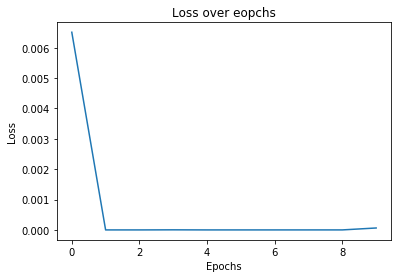

In [58]:
plt.plot(dictModel['totalLoss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over eopchs')

In [59]:

print("Accuracy = ",100*(dictModel['correct']/dictModel['totalSize']))

Accuracy =  93.86508659981769


In [60]:
dictModel['totalLoss']

[tensor(0.0065, grad_fn=<NllLossBackward>),
 tensor(0., grad_fn=<NllLossBackward>),
 tensor(0., grad_fn=<NllLossBackward>),
 tensor(2.8610e-06, grad_fn=<NllLossBackward>),
 tensor(0., grad_fn=<NllLossBackward>),
 tensor(0., grad_fn=<NllLossBackward>),
 tensor(0., grad_fn=<NllLossBackward>),
 tensor(1.1921e-07, grad_fn=<NllLossBackward>),
 tensor(2.3842e-07, grad_fn=<NllLossBackward>),
 tensor(6.3537e-05, grad_fn=<NllLossBackward>)]

In [61]:
#Saving model_ft
torch.save(obj=model_ft.state_dict(),f='vgg_prototype1_dict.pth')
torch.save(obj=model_ft,f='vgg_prototype1.pth')

In [62]:
dictModelVal = {}
model_val, dictModelVal = train_model(model_ft,mode=False,decay=False,criterion=criterion,optimizer=optimizer,dictionary=dictModelVal,scheduler=exp_lr_scheduler,dataloader=valDataLoader,num_epochs=1)

Epoch 0/0 


In [63]:

print("Accuracy validation set = ",100*dictModelVal['correct']/dictModelVal['totalSize'])

Accuracy validation set =  80.88235294117646


In [64]:
dictModelVal['totalLoss']

[tensor(1.3877, grad_fn=<NllLossBackward>)]